# Import bibliotek

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.utils import to_categorical
import numpy as np
import tifffile as tiff
import os
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Wczytanie danych

In [2]:
def shuffle_in_unison(a, b):
    """
    Miesza a i b, ale tak by indeksy dalej sobie odpowiadaly
    :param a: numpy array
    :param b: numpy array
    :return: pomieszane numpy arraye
    """
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [3]:
def read_data(path):
    """
    Zwraca dataset (data), etykiety numeryczne (labels) i nazwy klas/katalogow (classes)
    data, labels -> numpy array
    classes -> lista
    :param path: sciezka do katalogu z katalogami z danymi
    """
    cls = 0
    classes = {}
    data = []
    labels = []
    dirs = os.listdir(path)
    for dir in dirs:
        files = os.listdir(path + "/" + dir)
        for file in files:
            if not file.rsplit(".", 1)[1].lower() in ["tif"]:
                continue
            else:
                # wczytanie obrazu
                image = tiff.imread(path + "/" + dir + "/" + file)
                data.append(image)
                labels.append(cls)
        classes[cls] = dir
        cls += 1

    # miesza dane i etykiety, ale tak by nadal sobie odpowiadaly
    data = np.stack(data)
    data, labels = shuffle_in_unison(np.array(data), np.array(labels))
    return data, labels, classes

In [4]:
data, labels, classes = read_data("/home/mery/tif")
"Wymiar tensora z danymi wejściowymi: {}".format(data.shape)
"Wymiar wektora z etykietami danych wejśćiowych: {}".format(labels.shape)

# Podział danych na trenujące i walidacyjne

In [8]:
dataset_size = data.shape[0]
train_size = int(0.9 * dataset_size) # 90% datasetu (mozna tym manipulowac)
X_train = data[0:train_size, ]
y_train = labels[0:train_size]
X_test = data[train_size:, ]
y_test = labels[train_size:, ]

In [9]:
dataset_size

27000

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((24300, 64, 64, 13), (24300,), (2700, 64, 64, 13), (2700,))

# Wyświetlenie próbki danych

(64, 64)
2968


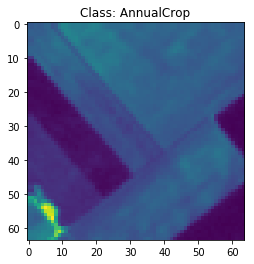

(64, 64)
1562


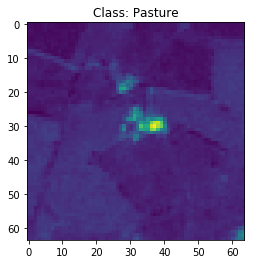

(64, 64)
1653


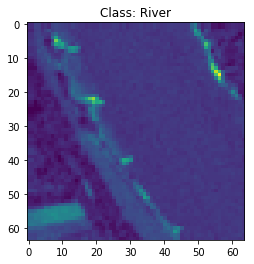

(64, 64)
3627


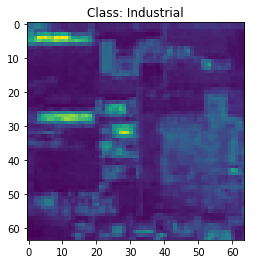

(64, 64)
883


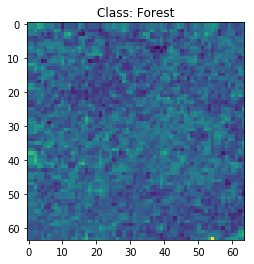

In [11]:
for idx in range(5):
    image = X_train[idx, :, :,1]
    plt.imshow(image)
    print(image.shape)
    print(np.max(image))
    plt.title('Class: {}'.format(classes[y_train[idx]]))
    plt.show()

# Normalizacja wartości obrazu

1. Jak wygląda sieć neuronowa?
<br>
<img src="https://obrazki.elektroda.pl/6823854300_1329765553.png">
<br>
Źródło: https://www.elektroda.pl/rtvforum/topic2174502.html

2. Funkcja aktywacji
<br>
Istnieją różne funkcje aktywacji (sigmoid, relu)
<br>
<img src="https://cdn-images-1.medium.com/max/1600/1*Be3Bhz0BA-NgZIYqRVZtug.gif">
<br>
Źródło: https://medium.com/@EspyMur/what-ive-learned-from-my-udacity-deep-learning-course-sigmoid-function-vs-softmax-function-e3e122334f34

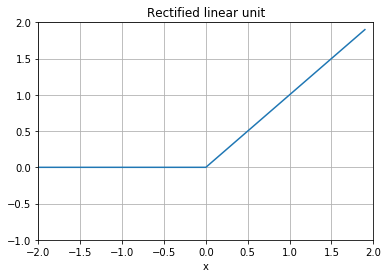

In [12]:
z = np.arange(-2, 2, .1)
zero = np.zeros(len(z))
y = np.max([zero, z], axis=0)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, y)
ax.set_ylim([-1.0, 2.0])
ax.set_xlim([-2.0, 2.0])
ax.grid(True)
ax.set_xlabel('x')
ax.set_title('Rectified linear unit')

plt.show()

3. Normalizacja danych wejściowych

In [13]:
np.max(X_train), np.min(X_train)

(28003, 0)

In [14]:
np.max(X_test), np.min(X_test)

(28000, 0)

In [15]:
X_train = X_train /np.max(X_train)
X_test = X_test / np.max(X_test)

In [16]:
np.max(X_train), np.min(X_train)

(1.0, 0.0)

In [17]:
np.max(X_test), np.min(X_test)

(1.0, 0.0)

# Kategoryzacja 

Konwersja wektora etykiet klas (numerycznych) do macierzy z samymi zerami i jedynką pod indeksem oznaczającym klasę
<br>
Jest to potrzebne do rachunku macierzowego

In [18]:
num_classes = np.unique(labels).shape[0]

In [19]:
num_classes

10

In [20]:
y_train[1]

3

In [21]:
if len(y_train.shape) == 1:
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

In [22]:
y_train[1]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

# Tworzenie modelu sieci neuronowej

1. Warstwa konwolucyjna
<br>
<img src="https://i1.wp.com/timdettmers.com/wp-content/uploads/2015/03/convolution.png?resize=500%2C193">
<br>
Źródło: https://timdettmers.com/2015/03/26/convolution-deep-learning/
<br>
<br>
2. Maxpooling
<br>
<img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png">
<br>
Źródło: https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png

In [23]:
input_shape = X_train[0].shape

In [24]:
model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_shape),
        # wartosci w kernelu sa zazwyczaj z rozkladu gaussa
        # liczba filtrow to liczba nalozen kernela
    
        MaxPool2D(pool_size=(2, 2)),  # pooling na przefiltrowanym bierze max z okna 2x2 i zmniejsza rozmiar img

        Conv2D(filters=64, kernel_size=(3, 3)),  # conv2d i pooling na wyniku pierwszego zestawu
        MaxPool2D(pool_size=(2, 2)),

        Flatten(),  # obrazek po konwolucjach -> liczba pikseli x 1

        Dense(512, activation='relu'),  # fullyconnected ma 512 neuronow, dokladane do flatten, mozna te liczbe zmieniac

        Dense(num_classes, activation='softmax')
    ])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.


# Trenowanie modelu

In [25]:
model.fit(
        X_train, y_train,
        batch_size=128, #dzielnik rozmiaru X_train
        epochs=3, #ok. 5-7
        validation_data=(X_test, y_test)
    )

Instructions for updating:
Use tf.cast instead.
Train on 24300 samples, validate on 2700 samples
Epoch 1/3
24300/24300 [==============================] - 113s 5ms/step - loss: 0.8992 - acc: 0.6721 - val_loss: 0.5907 - val_acc: 0.7800
Epoch 2/3
24300/24300 [==============================] - 110s 5ms/step - loss: 0.5159 - acc: 0.8171 - val_loss: 0.4538 - val_acc: 0.8448
Epoch 3/3
24300/24300 [==============================] - 110s 5ms/step - loss: 0.4088 - acc: 0.8588 - val_loss: 0.3708 - val_acc: 0.8744


# Testowanie

In [26]:
score = model.evaluate(X_test, y_test, verbose=0)  # zwraca [loss, accuracy]
score

[0.37083355841813265, 0.8744444443561412]

In [27]:
X_new = X_test[:5]
y_new_ground_truth = y_test[:5]

In [28]:
X_new.shape, y_new_ground_truth.shape

((5, 64, 64, 13), (5, 10))

In [29]:
y_new = model.predict(X_new)

In [30]:
classes

{0: 'Residential',
 1: 'AnnualCrop',
 2: 'PermanentCrop',
 3: 'Pasture',
 4: 'HerbaceousVegetation',
 5: 'River',
 6: 'Highway',
 7: 'Forest',
 8: 'Industrial',
 9: 'SeaLake'}

['0.05', '0.18', '0.13', '0.00', '0.01', '0.01', '0.30', '0.00', '0.32', '0.00']
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Rozpoznano: Industrial
Powinno byc: Highway


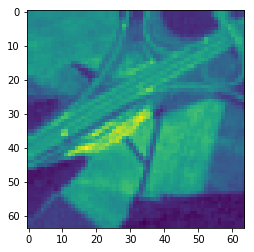

['0.00', '0.04', '0.00', '0.96', '0.00', '0.00', '0.00', '0.01', '0.00', '0.00']
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Rozpoznano: Pasture
Powinno byc: Pasture


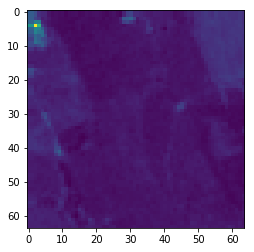

['0.01', '0.00', '0.00', '0.00', '0.00', '0.06', '0.93', '0.00', '0.00', '0.00']
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Rozpoznano: Highway
Powinno byc: Highway


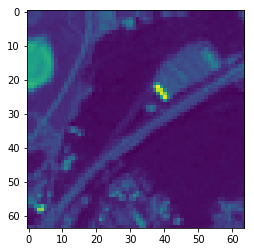

['0.00', '0.99', '0.00', '0.00', '0.00', '0.00', '0.01', '0.00', '0.00', '0.00']
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Rozpoznano: AnnualCrop
Powinno byc: AnnualCrop


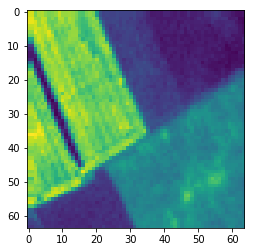

['0.04', '0.00', '0.02', '0.00', '0.00', '0.01', '0.92', '0.00', '0.00', '0.00']
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Rozpoznano: Highway
Powinno byc: Highway


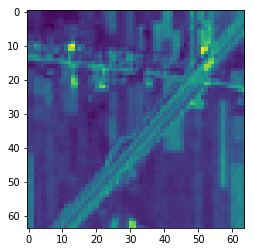

In [35]:
for i in range(len(X_new)):
    y_new_rounded = [ '%.2f' % elem for elem in y_new[i] ]
    y_new_ground_truth_rounded = [ '%.2f' % elem for elem in y_new_ground_truth[i] ]
    print(y_new_rounded, y_new_ground_truth[i], sep='\n')
    type(y_new_rounded)
    plt.imshow(X_test[i, :, :,1])
    print('Rozpoznano: {}'.format(classes[y_new_rounded.index(max(y_new_rounded))]))
    print('Powinno byc: {}'.format(classes[y_new_ground_truth_rounded.index(max(y_new_ground_truth_rounded))]))
    plt.show()